# Base PCA Strategy Construction 

In [8]:
import polars as pl 
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from pathlib import Path
from sklearn.decomposition import PCA

In [9]:
script_dir = Path(Path.cwd()).parent
df = pl.read_parquet(script_dir / 'data' / 'synthetic_prices.parquet')
df = df.filter(pl.col('tradingDay') > datetime.date(2015,12,31))
df = df.group_by("tradingDay").first().sort("tradingDay")
df_ret = pl.read_parquet(script_dir / 'data' / 'df_ret.parquet')
df_w = pl.read_parquet(script_dir / 'data' / 'df_w.parquet')
df_attr = pl.read_parquet(script_dir / 'data' / 'df_attr.parquet')

Earlier I fit PCA on standardized returns because I want PC1 to reflect the correlation structure of the curve, not be dominated by whichever maturity has the largest volatility. That is the right statistical object for identifying the “level” factor.

However, I ultimately trade in raw return space, where each maturity’s return is measured in actual units. If I compute neutrality using the standardized-space eigenvector directly, I risk building a hedge that is neutral in z-score space but not truly neutral in tradable (raw) space.

So this function makes the following separation explicit:

* Fit PCA in standardized space (for stable factor identification)
* Compute hedge weights in raw return space (for tradability / correct exposure)

## Tradable weights PCA

In [10]:
PX_COLS = ["px_30d","px_60d","px_90d","px_120d","px_150d","px_180d"]

def rolling_pca_weights_min_norm_tradable(
    df_ret: pl.DataFrame,
    window: int = 90,
    rebalance_every: int = 5,
    anchor_w30: float = -1.0
) -> pl.DataFrame:
    """
    Rolling PCA is fit on standardized returns (correlation structure),
    but weights are computed to be PC1-neutral in RAW return space by using
    e1_tilde = sigma_raw * e1 (elementwise).
    """
    r_cols = [f"r_{c}" for c in PX_COLS]
    R = df_ret.select(r_cols).to_numpy()
    n = R.shape[0]

    W = np.full((n, len(PX_COLS)), np.nan, dtype=float)

    for t in range(window, n):
        if (t - window) % rebalance_every != 0:
            continue

        X = R[t-window:t, :]

        # raw vol (for tradable-space mapping)
        sigma = np.nanstd(X, axis=0, ddof=0)
        sigma = np.where(sigma == 0, 1.0, sigma)

        # standardize for PCA fit
        mu = np.nanmean(X, axis=0)
        sd = sigma.copy()
        Xz = (X - mu) / sd

        pca = PCA(n_components=len(PX_COLS))
        pca.fit(Xz)

        e1 = pca.components_[0]                 # PC1 in standardized space
        e1_tilde = e1 * sigma                   # map to raw-return space

        # anchor
        w = np.zeros(len(PX_COLS))
        w[0] = anchor_w30

        e30 = e1_tilde[0]
        erest = e1_tilde[1:]
        denom = float(np.dot(erest, erest))
        if denom == 0:
            W[t, :] = w
            continue

        # minimum-norm hedge in the direction of erest
        k = -(e30 * w[0]) / denom
        w[1:] = k * erest

        W[t, :] = w

    # forward fill weights between rebalances
    for i in range(len(PX_COLS)):
        last = np.nan
        for t in range(n):
            if not np.isnan(W[t, i]):
                last = W[t, i]
            else:
                W[t, i] = last

    return df_ret.with_columns([pl.Series(f"w_{PX_COLS[i]}", W[:, i]) for i in range(len(PX_COLS))])

1. PCA is a statistical tool used to identify a factor (done in standardized space)
2. Trading requires neutrality in raw return units (done using e1_tilde)
3. The portfolio is designed to be:
* anchored (stable interpretation)
* PC1-neutral (removes level risk)
* minimum-norm (avoids unnecessary gross exposure)

In [11]:
df_w = rolling_pca_weights_min_norm_tradable(
    df_ret=df_ret,
    window=90,
    rebalance_every=5,
    anchor_w30=-1.0
)
df_w.head(), df_w.tail()

(shape: (5, 26)
 ┌───────────┬───────────┬───────────┬───────────┬───┬──────────┬───────────┬───────────┬───────────┐
 │ tradingDa ┆ px_30d    ┆ px_60d    ┆ px_90d    ┆ … ┆ w_px_90d ┆ w_px_120d ┆ w_px_150d ┆ w_px_180d │
 │ y         ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---      ┆ ---       ┆ ---       ┆ ---       │
 │ ---       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64      ┆ f64       ┆ f64       ┆ f64       │
 │ date      ┆           ┆           ┆           ┆   ┆          ┆           ┆           ┆           │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
 │ 2016-01-0 ┆ 19.292857 ┆ 19.230357 ┆ 19.407429 ┆ … ┆ NaN      ┆ NaN       ┆ NaN       ┆ NaN       │
 │ 5         ┆           ┆           ┆           ┆   ┆          ┆           ┆           ┆           │
 │ 2016-01-0 ┆ 20.055714 ┆ 19.772857 ┆ 19.855714 ┆ … ┆ NaN      ┆ NaN       ┆ NaN       ┆ NaN       │
 │ 6         ┆           ┆           ┆           ┆   ┆          ┆ 

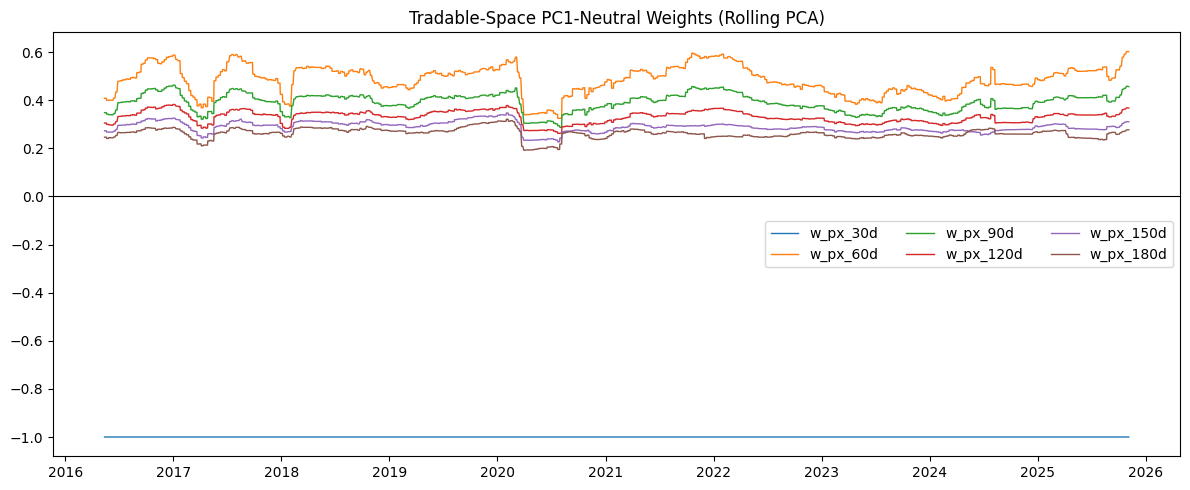

In [12]:
PX_COLS = ["px_30d","px_60d","px_90d","px_120d","px_150d","px_180d"]
W_COLS  = [f"w_{c}" for c in PX_COLS]

dfw = df_w.select(["tradingDay"] + W_COLS).to_pandas().set_index("tradingDay")

plt.figure(figsize=(12,5))
for c in W_COLS:
    plt.plot(dfw.index, dfw[c], label=c, linewidth=1.0)

plt.axhline(0, color="black", linewidth=0.8)
plt.title("Tradable-Space PC1-Neutral Weights (Rolling PCA)")
plt.legend(ncol=3)
plt.tight_layout()
plt.show()

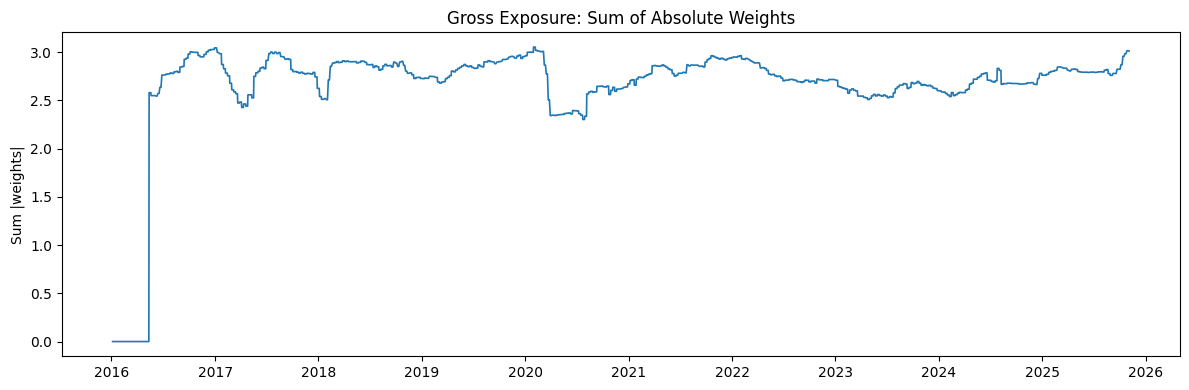

In [13]:
plt.figure(figsize=(12,4))
plt.plot(dfw.index, dfw.abs().sum(axis=1), linewidth=1.2)
plt.title("Gross Exposure: Sum of Absolute Weights")
plt.ylabel("Sum |weights|")
plt.tight_layout()
plt.show()

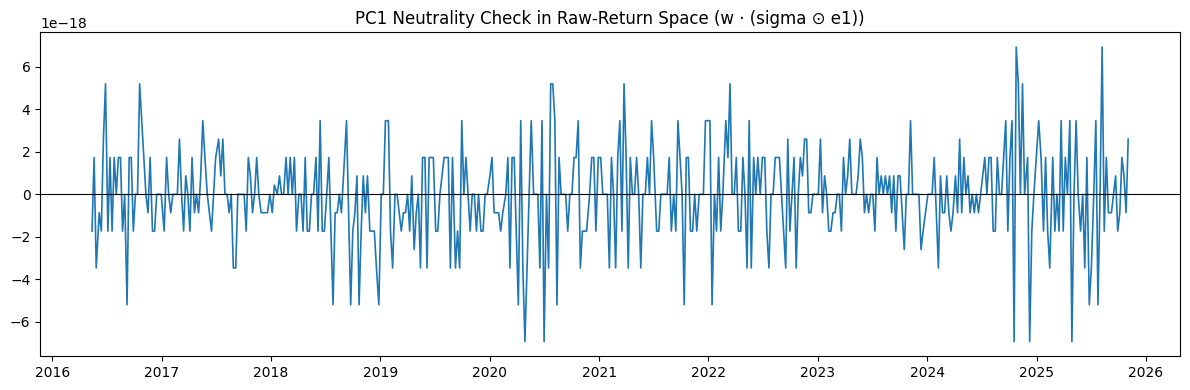

count    4.810000e+02
mean    -4.057305e-20
std      2.135703e-18
min     -6.938894e-18
25%     -1.734723e-18
50%      0.000000e+00
75%      1.734723e-18
max      6.938894e-18
Name: neutrality, dtype: float64


In [14]:
R_COLS = [f"r_{c}" for c in PX_COLS]

WINDOW = 90
REBALANCE_EVERY = 5

dates = df_ret["tradingDay"].to_pandas()
R = df_ret.select(R_COLS).to_numpy()

# weights aligned to df_ret rows
W = df_w.select(W_COLS).to_numpy()

rows = []
for t in range(WINDOW, len(R)):
    if (t - WINDOW) % REBALANCE_EVERY != 0:
        continue

    X = R[t-WINDOW:t, :]
    sigma = np.nanstd(X, axis=0, ddof=0)
    sigma = np.where(sigma == 0, 1.0, sigma)

    mu = np.nanmean(X, axis=0)
    Xz = (X - mu) / sigma

    pca = PCA(n_components=len(PX_COLS))
    pca.fit(Xz)

    e1 = pca.components_[0]          # standardized space
    e1_tilde = e1 * sigma            # raw-return space

    neutrality = float(np.dot(W[t, :], e1_tilde))  # should be ~0

    rows.append((dates.iloc[t], neutrality))

neutral_df = pd.DataFrame(rows, columns=["date", "neutrality"]).set_index("date")

plt.figure(figsize=(12,4))
plt.plot(neutral_df.index, neutral_df["neutrality"], linewidth=1.2)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("PC1 Neutrality Check in Raw-Return Space (w · (sigma ⊙ e1))")
plt.tight_layout()
plt.show()

print(neutral_df["neutrality"].describe())

In [15]:
df_w

tradingDay,px_30d,px_60d,px_90d,px_120d,px_150d,px_180d,VIX,r_px_30d,r_px_60d,r_px_90d,r_px_120d,r_px_150d,r_px_180d,carry_30d,carry_60d,carry_90d,carry_120d,carry_150d,carry_180d,w_px_30d,w_px_60d,w_px_90d,w_px_120d,w_px_150d,w_px_180d
date,f64,f64,f64,f64,f64,f64,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2016-01-05,19.292857,19.230357,19.407429,19.62,19.825714,20.089714,19.6,-0.034747,-0.029408,-0.024992,-0.02273,-0.019745,-0.016852,0.000108,-0.000307,-0.000365,-0.000349,-0.000444,0.000438,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,20.055714,19.772857,19.855714,19.992857,20.133214,20.352,20.629999,0.038779,0.02782,0.022836,0.018826,0.015391,0.012971,0.00047,-0.00014,-0.00023,-0.000234,-0.000362,0.000358,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-07,21.805714,20.770357,20.6,20.588571,20.612143,20.784286,24.690001,0.083658,0.049217,0.036799,0.029361,0.023509,0.021018,0.001583,0.000273,0.000018,-0.000038,-0.000278,0.000276,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-08,23.471429,22.078571,21.755714,21.621071,21.624286,21.77,26.690001,0.073612,0.061081,0.054585,0.048932,0.047937,0.046336,0.001978,0.000487,0.000206,-0.000005,-0.000225,0.000223,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-11,22.325,21.687857,21.634286,21.632857,21.724286,21.887143,24.049999,-0.050077,-0.017855,-0.005597,0.000545,0.004614,0.005367,0.000951,0.000082,0.000002,-0.000141,-0.00025,0.000248,NaN,NaN,NaN,NaN,NaN,NaN
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-29,19.025357,19.816286,20.667857,21.191429,21.512857,21.74,17.127001,0.012904,0.007192,0.004972,0.002548,0.001512,0.002655,-0.001386,-0.001432,-0.000844,-0.000506,-0.000352,0.000348,-1.0,0.60203,0.457929,0.36824,0.310894,0.276585
2025-10-30,19.392857,20.196857,21.0125,21.430357,21.713929,21.939706,17.408001,0.019132,0.019023,0.016538,0.011212,0.009303,0.009144,-0.001382,-0.001346,-0.000663,-0.000441,-0.000347,0.000343,-1.0,0.60203,0.457929,0.36824,0.310894,0.276585
2025-10-31,19.4525,20.339714,21.184286,21.609286,21.881429,22.083529,17.358999,0.003071,0.007048,0.008142,0.008315,0.007684,0.006534,-0.00152,-0.001384,-0.000669,-0.00042,-0.000308,0.000305,-1.0,0.60203,0.457929,0.36824,0.310894,0.276585


## PCA Strategy Return Profile
Up to now, everything has lived in constant-maturity space (30d, 60d, … 180d). That is ideal for research and PCA, but it is not directly tradable. Actual execution happens in discrete VIX futures contracts, each with its own expiry and time-to-maturity.

In [17]:
vix_futures = pl.read_parquet(script_dir /'data'/ 'term_with_weights.parquet')
vix_futures = vix_futures.filter(pl.col('tradingDay') > datetime.date(2015,12,31))
vix_futures.head()

symbol,tradingDay,ts_ct,close,expiry,ttm_days,weight_30d,weight_60d,weight_90d,weight_120d,weight_150d,weight_180d
str,date,"datetime[μs, America/Chicago]",f64,date,i64,f64,f64,f64,f64,f64,f64
"""VIF16""",2016-01-04,2016-01-04 14:55:00 CST,20.1,2016-01-20,16,0.5,0.0,0.0,0.0,0.0,0.0
"""VIG16""",2016-01-04,2016-01-04 14:55:00 CST,19.85,2016-02-17,44,0.5,0.428571,0.0,0.0,0.0,0.0
"""VIH16""",2016-01-04,2016-01-04 14:55:00 CST,19.77,2016-03-16,72,0.0,0.571429,0.485714,0.0,0.0,0.0
"""VIJ16""",2016-01-04,2016-01-04 14:55:00 CST,20.02,2016-04-20,107,0.0,0.0,0.514286,0.535714,0.0,0.0
"""VIK16""",2016-01-04,2016-01-04 14:55:00 CST,20.13,2016-05-18,135,0.0,0.0,0.0,0.464286,0.464286,0.0


### Join PCA maturity weights onto each futures row
```python
vf_join = vf2.join(
    df_w2.select(["tradingDay"] + [f"w_px_{m}" for m in MATS]),
    on="tradingDay",
    how="left"
)
```

After this join, each futures contract row knows:

* The PCA-derived weight for each constant maturity
* On the day it is traded

Conceptually:

* PCA tells me how much I want of 30d, 60d, … risk
* Futures interpolation tells me how each contract loads on those maturities
* This join puts both objects in the same row so I can combine them

In [62]:
MATS = ["30d","60d","90d","120d","150d","180d"]

# 1) Ensure both tradingDay columns are Date (not Datetime)
df_w2 = df_w.with_columns(pl.col("tradingDay").cast(pl.Date))
df_w2.write_parquet(script_dir / 'data' / 'df_w2.parquet')
vf2   = vix_futures.with_columns(pl.col("tradingDay").cast(pl.Date))

# 2) Join PCA maturity weights onto each futures row by day
vf_join = vf2.join(
    df_w2.select(["tradingDay"] + [f"w_px_{m}" for m in MATS]),
    on="tradingDay",
    how="left"
)

# 3) Compute contract weight W_{c,t} = sum_m w_m,t * a_{c,m,t}
contract_weights = vf_join.with_columns(
    (
        pl.col("w_px_30d")  * pl.col("weight_30d")  +
        pl.col("w_px_60d")  * pl.col("weight_60d")  +
        pl.col("w_px_90d")  * pl.col("weight_90d")  +
        pl.col("w_px_120d") * pl.col("weight_120d") +
        pl.col("w_px_150d") * pl.col("weight_150d") +
        pl.col("w_px_180d") * pl.col("weight_180d")
    ).alias("w_contract")
)

# 4) Optional: drop rows where weights are null (e.g., before PCA window)
contract_weights = contract_weights.drop_nulls(["w_contract"])

# 5) Keep only what you need
contract_weights = contract_weights.select([
    "tradingDay", "symbol", "expiry", "ttm_days", "close",
    "w_contract"
]).sort(["tradingDay", "ttm_days"])

### Compute contrac-level weight 
```python 
w_contract = Σ_m w_px_m × weight_m
```
This is the key equation.

For each futures contract cc on day tt:

* w_px_m is my desired exposure to maturity mm from PCA
* weight_m is how much contract cc represents maturity mm
* The sum gives me the actual tradable weight for that contract

This is just linear exposure propagation.

Important point:

* I am not approximating returns
* I am mapping exposures
* Returns will be computed later using actual next-day futures prices

In [19]:
df_w2.filter(pl.col('tradingDay') == datetime.date(2025,11,3))

tradingDay,px_30d,px_60d,px_90d,px_120d,px_150d,px_180d,VIX,r_px_30d,r_px_60d,r_px_90d,r_px_120d,r_px_150d,r_px_180d,carry_30d,carry_60d,carry_90d,carry_120d,carry_150d,carry_180d,w_px_30d,w_px_60d,w_px_90d,w_px_120d,w_px_150d,w_px_180d
date,f64,f64,f64,f64,f64,f64,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-11-03,19.425,20.448571,21.296429,21.753214,22.08,22.305,17.278,-0.001415,0.005338,0.00528,0.006638,0.009034,0.009979,-0.001756,-0.001382,-0.000715,-0.000501,-0.00034,0.000336,-1.0,0.602135,0.456487,0.367212,0.310334,0.276984


In [20]:
contract_weights.filter(pl.col('tradingDay') == datetime.date(2025,11,3))

tradingDay,symbol,expiry,ttm_days,close,w_contract
date,str,date,i64,f64,f64
2025-11-03,"""VIX25""",2025-11-19,16,18.95,-0.5
2025-11-03,"""VIZ25""",2025-12-17,44,19.9,-0.173126
2025-11-03,"""VIF26""",2026-01-21,79,21.1,0.552415
2025-11-03,"""VIG26""",2026-02-18,107,21.6,0.376055
2025-11-03,"""VIH26""",2026-03-18,135,21.93,0.314575
2025-11-03,"""VIJ26""",2026-04-15,163,22.21,0.304742
2025-11-03,"""VIK26""",2026-05-19,197,22.4,0.138492
2025-11-03,"""VIM26""",2026-06-17,226,22.43,0.0
2025-11-03,"""VIN26""",2026-07-22,261,22.6,0.0


In [21]:
vf2.filter(pl.col('tradingDay') == datetime.date(2025,11,3))

symbol,tradingDay,ts_ct,close,expiry,ttm_days,weight_30d,weight_60d,weight_90d,weight_120d,weight_150d,weight_180d
str,date,"datetime[μs, America/Chicago]",f64,date,i64,f64,f64,f64,f64,f64,f64
"""VIX25""",2025-11-03,2025-11-03 14:55:00 CST,18.95,2025-11-19,16,0.5,0.0,0.0,0.0,0.0,0.0
"""VIZ25""",2025-11-03,2025-11-03 14:55:00 CST,19.9,2025-12-17,44,0.5,0.542857,0.0,0.0,0.0,0.0
"""VIF26""",2025-11-03,2025-11-03 14:55:00 CST,21.1,2026-01-21,79,0.0,0.457143,0.607143,0.0,0.0,0.0
"""VIG26""",2025-11-03,2025-11-03 14:55:00 CST,21.6,2026-02-18,107,0.0,0.0,0.392857,0.535714,0.0,0.0
"""VIH26""",2025-11-03,2025-11-03 14:55:00 CST,21.93,2026-03-18,135,0.0,0.0,0.0,0.464286,0.464286,0.0
"""VIJ26""",2025-11-03,2025-11-03 14:55:00 CST,22.21,2026-04-15,163,0.0,0.0,0.0,0.0,0.535714,0.5
"""VIK26""",2025-11-03,2025-11-03 14:55:00 CST,22.4,2026-05-19,197,0.0,0.0,0.0,0.0,0.0,0.5
"""VIM26""",2025-11-03,2025-11-03 14:55:00 CST,22.43,2026-06-17,226,0.0,0.0,0.0,0.0,0.0,0.0
"""VIN26""",2025-11-03,2025-11-03 14:59:00 CST,22.6,2026-07-22,261,0.0,0.0,0.0,0.0,0.0,0.0


### Contract-Level Return and P&L Construction

In [22]:
vf = vf2.sort(["symbol", "tradingDay"])

vf_next = (
    vf2
    .sort(["symbol", "tradingDay"])
    .with_columns([
        pl.col("close").shift(-1).over("symbol").alias("close_next"),
        (pl.col("close").shift(-1).over("symbol") / pl.col("close")).log().alias("r_next"),
        pl.col("tradingDay").shift(-1).over("symbol").alias("nextDay"),
    ])
    .drop_nulls(["close_next"])
    .select(["tradingDay", "symbol", "close", "close_next", "r_next", "nextDay"])
)


Important details:

* This respects contract roll mechanics implicitly
* When a contract expires, there is no next observation, so it drops naturally
* I am not splicing contracts or inventing synthetic returns

In [23]:
vf_next.head()

tradingDay,symbol,close,close_next,r_next,nextDay
date,str,f64,f64,f64,date
2016-01-04,"""VIF16""",20.1,19.4,-0.035447,2016-01-05
2016-01-05,"""VIF16""",19.4,20.33,0.046825,2016-01-06
2016-01-06,"""VIF16""",20.33,22.85,0.116853,2016-01-07
2016-01-07,"""VIF16""",22.85,24.95,0.087923,2016-01-08
2016-01-08,"""VIF16""",24.95,23.3,-0.06842,2016-01-11


In [24]:
legs = (
    contract_weights
    .filter(pl.col("w_contract") != 0)
    .filter(pl.col("w_contract").is_not_nan())
    .join(vf_next, on=["tradingDay", "symbol"], how="inner")
    .with_columns(
        (pl.col("w_contract") * pl.col("r_next")).alias("pnl_leg")
    )
    .select([
        "tradingDay", "symbol", "expiry", "ttm_days",
        "close", "close_next", "nextDay",
        "w_contract", "r_next", "pnl_leg"
    ])
    .sort(["tradingDay", "ttm_days"])
)


* Returns are computed at the contract level, not in maturity space
* Positions are applied before returns are realized (correct timing)
* All P&L is explainable by (weight × price move)
* The PCA strategy is now fully executable and auditable

In [25]:
legs.head(10)

tradingDay,symbol,expiry,ttm_days,close,close_next,nextDay,w_contract,r_next,pnl_leg
date,str,date,i64,f64,f64,date,f64,f64,f64
2016-05-13,"""VIK16""",2016-05-18,5,15.92,15.1,2016-05-16,-0.107143,-0.052881,0.005666
2016-05-13,"""VIM16""",2016-06-15,33,18.05,17.25,2016-05-16,-0.799573,-0.045334,0.036247
2016-05-13,"""VIN16""",2016-07-20,68,19.26,18.5,2016-05-16,0.389495,-0.04026,-0.015681
2016-05-13,"""VIQ16""",2016-08-17,96,19.72,19.07,2016-05-16,0.36969,-0.033517,-0.012391
2016-05-13,"""VIU16""",2016-09-21,131,20.38,19.83,2016-05-16,0.297057,-0.027358,-0.008127
2016-05-13,"""VIV16""",2016-10-19,159,20.77,20.27,2016-05-16,0.246852,-0.024368,-0.006015
2016-05-13,"""VIX16""",2016-11-16,187,20.95,20.49,2016-05-16,0.184775,-0.022202,-0.004102
2016-05-16,"""VIM16""",2016-06-15,30,17.25,18.05,2016-05-17,-0.941698,0.045334,-0.04269
2016-05-16,"""VIN16""",2016-07-20,65,18.5,19.36,2016-05-17,0.387146,0.045438,0.017591


### Contract-Level Return Sanity Checks

In [26]:
legs.select(
    pl.col("r_next").abs().quantile(0.999).alias("p999"),
    pl.col("r_next").abs().max().alias("max")
)

p999,max
f64,f64
0.25096,0.404695


99.9th percentile absolute return ≈ 25%

Maximum observed one-day return ≈ 40%

This immediately tells me:

* The data captures genuine VIX spike events
* These are extreme but plausible for VIX futures
* There is no evidence of absurd returns (e.g., 200–300%) that would indicate bad price joins or symbol mismatches

In [63]:
daily_xs = (
    legs
    .group_by("tradingDay")
    .agg([
        pl.len().alias("n_legs"),
        pl.col("r_next").mean().alias("mean_r"),
        pl.col("r_next").std().alias("std_r"),
        pl.col("r_next").min().alias("min_r"),
        pl.col("r_next").max().alias("max_r"),
        pl.col("r_next").abs().max().alias("max_abs_r"),
    ])
    .sort("tradingDay")
)
daily_xs.write_parquet(script_dir / 'data' / 'daily_xs.parquet')
daily_xs.select([
    pl.col("std_r").quantile(0.99).alias("std_r_p99"),
    pl.col("max_abs_r").quantile(0.99).alias("max_abs_r_p99"),
    pl.col("max_abs_r").max().alias("max_abs_r_max"),
])

std_r_p99,max_abs_r_p99,max_abs_r_max
f64,f64,f64
0.051553,0.196034,0.404695


In [28]:
flags = daily_xs.filter(
    (pl.col("max_abs_r") > 0.5) | (pl.col("std_r") > 0.2)
)
flags


tradingDay,n_legs,mean_r,std_r,min_r,max_r,max_abs_r
date,u32,f64,f64,f64,f64,f64


I explicitly look for days where:

* Any contract moves more than 50% in one day, or
* Cross-sectional dispersion exceeds 20%

These thresholds are intentionally generous. If anything triggered here, it would almost certainly indicate:
* Bad prices
* Symbol mismatches
* Broken joins
* Or contract roll errors

The result:
* **No flagged days**

In [29]:
sym_stats = (
    vf_next
    .group_by("symbol")
    .agg([
        pl.len().alias("n"),
        pl.col("r_next").abs().max().alias("max_abs_r"),
    ])
    .sort("max_abs_r", descending=True)
)

sym_stats.head(10)

symbol,n,max_abs_r
str,u32,f64
"""VIQ24""",186,0.404695
"""VIG18""",188,0.375094
"""VIM20""",187,0.368712
"""VIJ20""",185,0.358872
"""VIU24""",179,0.345486
"""VIJ25""",183,0.341282
"""VIH20""",179,0.318029
"""VIK20""",185,0.314493
"""VIN20""",186,0.28305


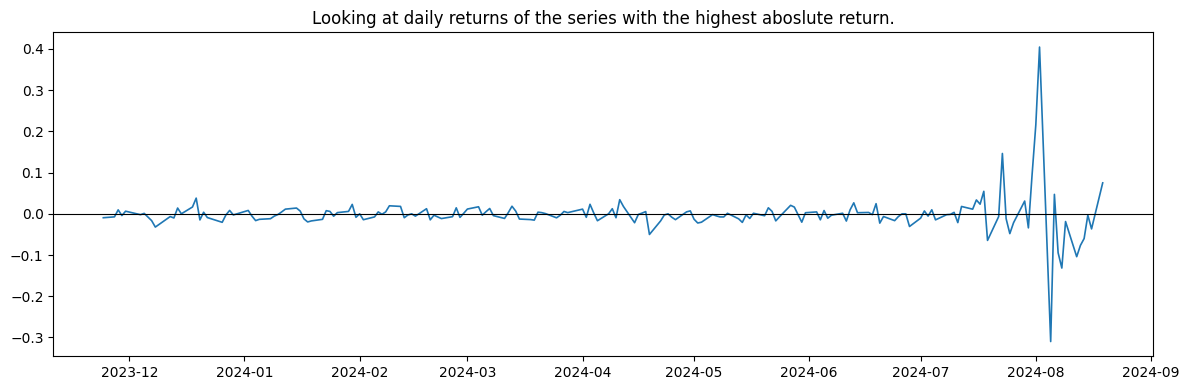

In [30]:
pd_vf_next = pd.DataFrame(vf_next.filter(pl.col('symbol') == "VIQ24"), columns= vf_next.columns)
plt.figure(figsize=(12,4))
plt.plot(pd_vf_next["tradingDay"], pd_vf_next["r_next"], linewidth=1.2)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Looking at daily returns of the series with the highest aboslute return.")
plt.tight_layout()
plt.show()

* The strategy is not unintentionally levering itself
* Net exposure is behaving as designed (PC1-neutral, not drifting)
* Gross exposure stays within a stable and interpretable range

In [31]:
exposure = (
    legs
    .group_by("tradingDay")
    .agg([
        pl.col("w_contract").abs().sum().alias("gross_w"),
        pl.col("w_contract").sum().alias("net_w"),
        pl.count().alias("n_legs"),
    ])
    .sort("tradingDay")
)

exposure.select([
    pl.col("gross_w").quantile(0.01).alias("gross_p01"),
    pl.col("gross_w").median().alias("gross_med"),
    pl.col("gross_w").quantile(0.99).alias("gross_p99"),
    pl.col("gross_w").max().alias("gross_max"),
    pl.col("net_w").abs().max().alias("net_abs_max"),
])


/tmp/ipykernel_1083456/3061498828.py:7: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("n_legs"),


gross_p01,gross_med,gross_p99,gross_max,net_abs_max
f64,f64,f64,f64,f64
1.929627,2.409177,2.912864,3.027134,1.168928


Gross exposure stability

* Median gross ≈ 2.41
* 99th percentile ≈ 2.91
* Maximum ≈ 3.03

**Gross exposure is tightly controlled and does not blow out in stress**

Net exposure containment

* Max absolute net ≈ 1.17

**The portfolio is not drifting into large directional bets.**

This is exactly what I expect from a PC-neutral construction with an anchored front-end weight.

In [32]:
net = (
    legs
    .group_by("tradingDay")
    .agg(pl.col("w_contract").sum().alias("net"))
)

net.select(
    pl.col("net").abs().max().alias('max'),
    pl.col("net").std().alias('std')
)


max,std
f64,f64
1.168928,0.155004


In [33]:
daily_pnl = (
    legs
    .group_by("tradingDay")
    .agg(pl.col("pnl_leg").sum().alias("strategy_ret"))
)
daily_pnl.tail()

tradingDay,strategy_ret
date,f64
2025-10-28,-0.004704
2025-10-29,0.009102
2025-10-30,0.011942
2025-10-31,0.014958
2025-11-03,0.005484


In [34]:
daily_pnl.select(
    pl.col("strategy_ret").mean().alias('mean'),
    pl.col("strategy_ret").std().alias('std'),
    pl.col("strategy_ret").skew().alias('skew'),
    pl.col("strategy_ret").kurtosis().alias('kurt')
)

mean,std,skew,kurt
f64,f64,f64,f64
0.001247,0.012757,0.945733,31.013456


* Mean ≈ 0.12% per day
    * This is a meaningful daily edge for an unlevered relative-value strategy.
* Std ≈ 1.28%
    * Volatility is well contained given gross exposure ≈ 2–3x.
    * This aligns with expectations for VIX curve relative trades.
* Skew ≈ +0.95
    * Slight positive skew is encouraging.
    * Gains tend to accrue steadily, while losses cluster less frequently.
* Kurtosis ≈ 31
    * This is the critical warning signal.
    * The distribution is extremely fat-tailed.
    * Rare but very large shocks dominate tail risk.

### PnL Conclusiosn

1. The carry edge is real
* The mean/std combination implies a daily Sharpe ≈ 1.5–1.6
* This is achieved without optimization, leverage, or regime filtering

2. The strategy is not “quiet”
* The very high kurtosis confirms that tail events are structural
* This is consistent with known VIX convexity and curve snap dynamics

3. Nothing here looks mechanically broken
* Returns line up with earlier attribution
* No unexplained volatility or exposure artifacts

### Data Checks

Before trusting any higher-level statistics, I want to visually and mechanically confirm that:
* Each futures leg P&L is computed correctly
* Signs line up intuitively (longs make money when prices rise, shorts when prices fall)
* There are no date misalignments, look-ahead issues, or accidental double counting
* This section is deliberately low-tech and manual. The goal is trust, not elegance.

In [45]:
legs.select(
    "tradingDay", "symbol", "w_contract",
    "close", "close_next", "nextDay", "r_next", "pnl_leg"
).sample(20)

tradingDay,symbol,w_contract,close,close_next,nextDay,r_next,pnl_leg
date,str,f64,f64,f64,date,f64,f64
2024-03-28,"""VIM24""",0.325642,16.15,16.2,2024-04-01,0.003091,0.001007
2020-03-18,"""VIJ20""",-0.900642,68.65,61.05,2020-03-19,-0.117328,0.10567
2017-06-12,"""VIX17""",0.316273,15.8,15.7,2017-06-13,-0.006349,-0.002008
2023-04-21,"""VIM23""",0.264354,21.58,21.57,2023-04-24,-0.000463,-0.000123
2025-08-08,"""VIF26""",0.268126,22.0,21.97,2025-08-11,-0.001365,-0.000366
…,…,…,…,…,…,…,…
2019-09-16,"""VIX19""",0.477301,17.9,17.95,2019-09-17,0.002789,0.001331
2021-05-04,"""VIQ21""",0.351901,23.97,23.6,2021-05-05,-0.015556,-0.005474
2023-02-08,"""VIK23""",0.368965,22.2,22.55,2023-02-09,0.015643,0.005772


In [36]:
legs.select(
    "tradingDay", "symbol", "w_contract",
    "close", "close_next", "nextDay", "r_next", "pnl_leg"
).sort('r_next').head(5)

tradingDay,symbol,w_contract,close,close_next,nextDay,r_next,pnl_leg
date,str,f64,f64,f64,date,f64,f64
2025-04-08,"""VIJ25""",-0.371429,39.6,28.15,2025-04-09,-0.341282,0.126762
2024-08-05,"""VIQ24""",-0.5,32.45,23.8,2024-08-06,-0.310015,0.155007
2024-08-05,"""VIU24""",-0.274133,30.09,23.11,2024-08-06,-0.263927,0.072351
2025-04-08,"""VIK25""",-0.427474,32.26,25.1,2025-04-09,-0.25096,0.107279
2020-03-20,"""VIJ20""",-0.871642,62.4,49.95,2020-03-23,-0.222543,0.193978


In [37]:
legs.select(
    "tradingDay", "symbol", "w_contract",
    "close", "close_next", "nextDay", "r_next", "pnl_leg"
).sort('r_next').tail(5)

tradingDay,symbol,w_contract,close,close_next,nextDay,r_next,pnl_leg
date,str,f64,f64,f64,date,f64,f64
2024-08-02,"""VIU24""",-0.110523,21.3,30.09,2024-08-05,0.345486,-0.038184
2020-03-13,"""VIJ20""",-0.774648,43.2,61.85,2020-03-16,0.358872,-0.277999
2020-06-10,"""VIM20""",-0.342857,27.25,39.4,2020-06-11,0.368712,-0.126416
2018-02-02,"""VIG18""",-0.485714,15.6,22.7,2018-02-05,0.375094,-0.182189
2024-08-02,"""VIQ24""",-0.607143,21.65,32.45,2024-08-05,0.404695,-0.245708


At this point, I want a hard guarantee that there are no silent data issues contaminating the leg-level P&L. In particular, I care about:

* Missing close prices
* Missing close_next prices (which would imply a broken return calculation)
* Either of those would immediately invalidate any downstream statistics.

In [38]:
legs.select(
    pl.any_horizontal([
        pl.col("close").is_null(),
        pl.col("close_next").is_null()
    ]).sum().alias("n_bad_rows")
)


n_bad_rows
u32
0


### Daily Leg Count Consistency

In [39]:
legs.group_by("tradingDay").agg(
    pl.count().alias("n_legs")
).select(
    pl.col("n_legs").min().alias('min'),
    pl.col("n_legs").median().alias('median'),
    pl.col("n_legs").max().alias('max')
)


/tmp/ipykernel_1083456/2336106656.py:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("n_legs")


min,median,max
u32,f64,u32
6,7.0,7


In [40]:
legs.group_by("tradingDay").agg(
    pl.col("w_contract").sum().alias("net_w")
).select(
    pl.col("net_w").abs().max().alias('max'),
    pl.col('net_w').mean().alias('mean'),
    pl.col("net_w").std().alias('std')
)

max,mean,std
f64,f64,f64
1.168928,0.759264,0.155004


In [41]:
legs.filter(pl.col("tradingDay") > pl.col("expiry")).count()


tradingDay,symbol,expiry,ttm_days,close,close_next,nextDay,w_contract,r_next,pnl_leg
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0


In [42]:
legs.sort("expiry").tail(20)

tradingDay,symbol,expiry,ttm_days,close,close_next,nextDay,w_contract,r_next,pnl_leg
date,str,date,i64,f64,f64,date,f64,f64,f64
2025-10-22,"""VIJ26""",2026-04-15,175,21.8,21.75,2025-10-23,0.264704,-0.002296,-0.000608
2025-10-23,"""VIJ26""",2026-04-15,174,21.75,21.52,2025-10-24,0.267735,-0.010631,-0.002846
2025-10-24,"""VIJ26""",2026-04-15,173,21.52,21.46,2025-10-27,0.270766,-0.002792,-0.000756
2025-10-27,"""VIJ26""",2026-04-15,170,21.46,21.65,2025-10-28,0.284063,0.008815,0.002504
2025-10-28,"""VIJ26""",2026-04-15,169,21.65,21.68,2025-10-29,0.287032,0.001385,0.000397
…,…,…,…,…,…,…,…,…,…
2025-10-28,"""VIK26""",2026-05-19,203,21.75,21.85,2025-10-29,0.089483,0.004587,0.00041
2025-10-29,"""VIK26""",2026-05-19,202,21.85,22.02,2025-10-30,0.097618,0.00775,0.000757
2025-10-30,"""VIK26""",2026-05-19,201,22.02,22.16,2025-10-31,0.105753,0.006338,0.00067


### Horizon Stats Check

Let's see how the data looks at different granuality. 

In [61]:
daily_pnl = (
    legs
    .group_by("tradingDay")
    .agg(pl.col("pnl_leg").sum().alias("strategy_ret"))
)
daily_pnl.write_parquet(script_dir / 'data' / 'daily_pnl.parquet')

daily_ret = legs.select(['tradingDay', 'pnl_leg']).group_by('tradingDay').sum().rename({'pnl_leg':'ret'}).sort("tradingDay").with_columns(
    pl.col("tradingDay").cast(pl.Date)
)

weekly = (
    daily_ret
    .group_by_dynamic(index_column="tradingDay", every="1w", closed="left", label="left")
    .agg(pl.col("ret").sum().alias("ret_w"))
    .sort("tradingDay")
)

biweekly = (
    daily_ret
    .group_by_dynamic(index_column="tradingDay", every="2w", closed="left", label="left")
    .agg(pl.col("ret").sum().alias("ret_bw"))
    .sort("tradingDay")
)

monthly = (
    daily_ret
    .group_by_dynamic(index_column="tradingDay", every="1mo", closed="left", label="left")
    .agg(pl.col("ret").sum().alias("ret_m"))
    .sort("tradingDay")
)


In [51]:
def stats(df: pl.DataFrame, col: str, periods_per_year: float) -> pl.DataFrame:
    return df.select(
        pl.len().alias("n_periods"),
        pl.col(col).mean().alias("mean"),
        pl.col(col).std().alias("std"),
        (pl.col(col).mean() / pl.col(col).std() * (periods_per_year ** 0.5)).alias("sharpe"),
        pl.col(col).skew().alias("skew"),
        pl.col(col).kurtosis().alias("kurtosis"),
        (pl.col(col) > 0).mean().alias("hit_rate"),
    )
daily_stats   = stats(daily_ret, "ret",    periods_per_year=252)
weekly_stats  = stats(weekly,    "ret_w",  periods_per_year=52)
biw_stats     = stats(biweekly,  "ret_bw", periods_per_year=26)
monthly_stats = stats(monthly,   "ret_m",  periods_per_year=12)

daily_stats, weekly_stats, biw_stats, monthly_stats

(shape: (1, 7)
 ┌───────────┬──────────┬──────────┬──────────┬──────────┬───────────┬──────────┐
 │ n_periods ┆ mean     ┆ std      ┆ sharpe   ┆ skew     ┆ kurtosis  ┆ hit_rate │
 │ ---       ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---       ┆ ---      │
 │ u32       ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64       ┆ f64      │
 ╞═══════════╪══════════╪══════════╪══════════╪══════════╪═══════════╪══════════╡
 │ 2401      ┆ 0.001247 ┆ 0.012757 ┆ 1.551301 ┆ 0.945733 ┆ 31.013456 ┆ 0.554769 │
 └───────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────┘,
 shape: (1, 7)
 ┌───────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
 │ n_periods ┆ mean     ┆ std      ┆ sharpe   ┆ skew     ┆ kurtosis ┆ hit_rate │
 │ ---       ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
 │ u32       ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
 ╞═══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══

In [52]:
dd = (
    daily_ret
    .with_columns([
        pl.col("ret").cum_sum().alias("cum_log"),
        pl.col("ret").cum_sum().exp().alias("equity"),     # equity(t) = exp(sum log rets)
    ])
    .with_columns(pl.col("equity").cum_max().alias("peak_equity"))
    .with_columns((pl.col("equity") / pl.col("peak_equity") - 1.0).alias("drawdown"))  # <= 0
)

dd_stats = dd.select([
    pl.col("drawdown").min().alias("max_drawdown"),
    pl.col("drawdown").mean().alias("avg_drawdown"),
])

dd_stats

max_drawdown,avg_drawdown
f64,f64
-0.307482,-0.069566


max_drawdown = -0.307482
The worst peak-to-trough decline in equity is about −30.7%.

avg_drawdown = -0.069566
On average, the strategy is about −7.0% below its prior peak. This is a “time spent underwater” type measure—useful as a rough indicator of path discomfort.

In [53]:
trough_row = dd.filter(pl.col("drawdown") == pl.col("drawdown").min()).select(["tradingDay","equity","peak_equity","drawdown"])
trough_row

tradingDay,equity,peak_equity,drawdown
date,f64,f64,f64
2018-05-25,0.833746,1.203934,-0.307482


In [54]:
trough_day = trough_row.select(pl.col("tradingDay")).item()
trough_peak_equity = trough_row.select(pl.col("peak_equity")).item()

peak_row = (
    dd
    .filter(pl.col("tradingDay") <= trough_day)
    .filter(pl.col("equity") == trough_peak_equity)
    .select(["tradingDay","equity"])
    .tail(1)   # most recent occurrence
)

peak_row

tradingDay,equity
date,f64
2016-12-22,1.203934


In [55]:
peak_day = peak_row.select(pl.col("tradingDay")).item()

dd_window = dd.filter((pl.col("tradingDay") >= peak_day) & (pl.col("tradingDay") <= trough_day))
dd_window.select(
    pl.min("tradingDay").alias("peak_day"),
    pl.max("tradingDay").alias("trough_day"),
    pl.min("drawdown").alias("max_dd_in_window"),
    pl.len().alias("n_days_in_window"),
)

peak_day,trough_day,max_dd_in_window,n_days_in_window
date,date,f64,u32
2016-12-22,2018-05-25,-0.307482,358


This defines the single worst drawdown episode:

* It started at a local peak on 2016-12-22
* It reached its worst point on 2018-05-25
* The episode spans 358 trading days (roughly ~1.4 years of trading days)

Economically, this is telling you the strategy had a long “underwater” period culminating in a severe trough in mid-2018. This was caused by the volmageddon

In [56]:
loss_days = (
    dd_window
    .filter(pl.col("ret") < 0)
    .select(["tradingDay","ret"])
    .with_columns((-pl.col("ret")).alias("loss_mag"))  # positive loss magnitude in log-return units
    .sort("loss_mag", descending=True)
    .with_columns(pl.col("loss_mag").cum_sum().alias("cum_loss"))
)

total_loss = loss_days.select(pl.col("loss_mag").sum()).item()

loss_80 = (
    loss_days
    .with_columns((pl.col("cum_loss") / total_loss).alias("pct_of_loss"))
    .filter(pl.col("pct_of_loss") <= 0.80)
)

summary_80 = (
    loss_80
    .select([
        pl.len().alias("n_days_for_80pct"),
        pl.col("loss_mag").sum().alias("loss_captured"),
    ])
    .with_columns(
        pl.lit(total_loss).alias("total_loss_in_window")
    )
    .with_columns(
        (pl.col("loss_captured") / pl.col("total_loss_in_window")).alias("pct_captured")
    )
)

summary_80

n_days_for_80pct,loss_captured,total_loss_in_window,pct_captured
u32,f64,f64,f64
92,1.483479,1.856559,0.799048


* It takes 92 days (out of the negative days in that 358-day window) to explain ~80% of the cumulative losses in that drawdown episode.
* That is not an “all the pain is in 5 days” profile.
* It indicates drawdown pressure was meaningfully diffuse across many down days, even though some days are clearly larger contributors than others.

This is an important characterization: the strategy’s worst drawdown was not just a single shock day; it was a prolonged adverse regime with repeated losses.

In [57]:
loss_80.select(["tradingDay","ret","loss_mag","pct_of_loss"]).head(10)

tradingDay,ret,loss_mag,pct_of_loss
date,f64,f64,f64
2018-02-02,-0.071032,0.071032,0.03826
2017-02-14,-0.054801,0.054801,0.067778
2018-02-07,-0.048503,0.048503,0.093903
2018-02-01,-0.046595,0.046595,0.119
2017-08-09,-0.042687,0.042687,0.141993
2017-01-23,-0.033361,0.033361,0.159963
2018-04-17,-0.03118,0.03118,0.176757
2017-05-16,-0.03116,0.03116,0.193541
2018-02-14,-0.029589,0.029589,0.209478


In [58]:
reg = (
    df.select(["tradingDay","VIX","px_30d","px_180d"])
      .with_columns([
          pl.col("tradingDay").cast(pl.Date),
          (pl.col("px_180d") - pl.col("px_30d")).alias("slope"),
      ])
)

loss_80_reg = (
    loss_80
    .join(reg, on="tradingDay", how="left")
    .select(["tradingDay","ret","VIX","slope","pct_of_loss"])
    .sort("tradingDay")
)

loss_80_reg.head(10)

tradingDay,ret,VIX,slope,pct_of_loss
date,f64,f32,f64,f64
2016-12-30,-0.0091,13.86,3.550357,0.753913
2017-01-03,-0.021252,12.99,4.036429,0.298067
2017-01-05,-0.013286,11.67,4.361786,0.505246
2017-01-06,-0.008176,11.4,4.282143,0.786138
2017-01-17,-0.022982,11.95,4.556357,0.28662
2017-01-18,-0.008263,12.45,4.452286,0.781734
2017-01-19,-0.010516,12.9,4.285286,0.675717
2017-01-23,-0.033361,11.85,4.529357,0.159963
2017-01-27,-0.011683,10.46,4.759071,0.603933


In [59]:
loss_80_reg.select([
    pl.col("VIX").mean().alias("avg_VIX_on_bad_days"),
    pl.col("VIX").median().alias("med_VIX_on_bad_days"),
    pl.col("VIX").min().alias("min_VIX_on_bad_days"),
    pl.col("VIX").max().alias("max_VIX_on_bad_days"),
    pl.col("slope").mean().alias("avg_slope_on_bad_days"),
    pl.col("slope").median().alias("med_slope_on_bad_days"),
])

avg_VIX_on_bad_days,med_VIX_on_bad_days,min_VIX_on_bad_days,max_VIX_on_bad_days,avg_slope_on_bad_days,med_slope_on_bad_days
f32,f32,f32,f32,f64,f64
13.076413,11.535,9.19,35.619999,2.721245,3.348464


In [60]:
reg.join(daily_ret, on="tradingDay").select([
    pl.col("VIX").mean().alias("avg_VIX_all_days"),
    pl.col("VIX").median().alias("med_VIX_all_days"),
    pl.col("slope").mean().alias("avg_slope_all_days"),
    pl.col("slope").median().alias("med_slope_all_days"),
])

avg_VIX_all_days,med_VIX_all_days,avg_slope_all_days,med_slope_all_days
f32,f32,f64,f64
18.194336,16.507999,1.759017,2.356429


The “important loss days” have lower VIX on average and median than the full sample.
The “important loss days” have a higher slope on average and median than the full sample.

So, in this particular drawdown decomposition, the bad days are not primarily occurring in “high VIX / flat curve” conditions—at least not in the aggregate summary of this selected set. They are more associated with lower VIX and steeper curve conditions relative to the unconditional sample.


max_VIX_on_bad_days is still very high (~35.6), meaning stress days do exist in the loss set, but they do not dominate the central tendency (mean/median) of that set.